Reconstruction:

Definition: In tomographic imaging, reconstruction refers to the process of creating a two-dimensional or three-dimensional image of an object from its projection data. The projections are typically obtained from various angles around the object, and the reconstruction algorithms use this data to compute an image that represents the internal structure of the object.
Usage: Reconstruction is a fundamental step in techniques like computed tomography (CT), magnetic resonance imaging (MRI), and other medical imaging modalities, as well as in industrial and scientific imaging applications.

Filtered Back Projection (FBP):

Definition: FBP is a common and straightforward method for tomographic reconstruction. It involves applying a filter to the sinogram data and then back-projecting the filtered data over the image space to reconstruct the original image.
Usage: Often used in medical imaging (e.g., CT scans) due to its simplicity and efficiency.
Simultaneous Iterative Reconstruction Technique (SIRT):

Definition: SIRT is an iterative method for tomographic reconstruction. It starts with an initial guess of the image and iteratively refines the guess by comparing the projections of the guess with the actual sinogram data.
Usage: Suitable for cases where the projection data is noisy or incomplete, as it can provide more accurate reconstructions through iterations.
Fourier-based Reconstruction (using Fourier Slice Theorem):

Definition: This method uses the Fourier Slice Theorem, which states that the Fourier transform of a projection of the object (sinogram) is a slice of the Fourier transform of the object itself. The reconstruction involves transforming the projections into the frequency domain, combining them, and then transforming back to the spatial domain.
Usage: This method is mathematically elegant and can be efficient, but it is sensitive to noise and often less used in practical applications compared to FBP and iterative methods.
These methods provide different approaches to reconstructing images from projection data, each with its own advantages and suitable use cases.

In [ ]:
!pip install scikit-image

In [17]:
!pip install --upgrade scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 21.6 MB/s eta 0:00:00
  Attempting uninstall: imageio
    Found existing installation: imageio 2.31.6
    Uninstalling imageio-2.31.6:
      Successfully uninstalled imageio-2.31.6
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3


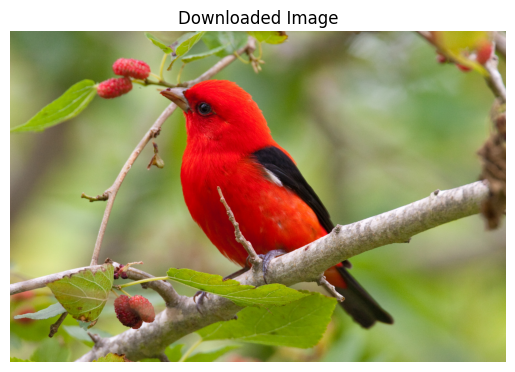

In [ ]:
import requests
from io import BytesIO
from skimage import io
import matplotlib.pyplot as plt

# Specify the URL of the image
url = "https://chilternchatter.com/wp-content/uploads/2018/01/RED-Bird.jpg"

# Step 1: Download the image from the internet
response = requests.get(url)
response.raise_for_status()  # Ensure the request was successful

# Step 2: Load the image into memory using BytesIO
image_bytes = BytesIO(response.content)
image = io.imread(image_bytes)

# Step 3: Display the downloaded image
plt.imshow(image)
plt.title('Downloaded Image')
plt.axis('off')
plt.show()


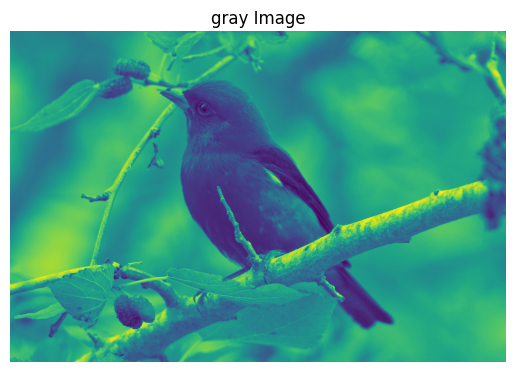

In [7]:
import requests
from io import BytesIO
from skimage import io
import matplotlib.pyplot as plt
from skimage import io, color

# Specify the URL of the image
url = "https://chilternchatter.com/wp-content/uploads/2018/01/RED-Bird.jpg"

# Step 1: Download the image from the internet
response = requests.get(url)
response.raise_for_status()  # Ensure the request was successful

# Step 2: Load the image into memory using BytesIO
image_bytes = BytesIO(response.content)
image = io.imread(image_bytes)

# Step 3: Convert the image to grayscale if it is not already
if image.ndim == 3:
    image = color.rgb2gray(image)
    # Step 3: Display the downloaded image
plt.imshow(image)
plt.title('gray Image')
plt.axis('off')
plt.show()

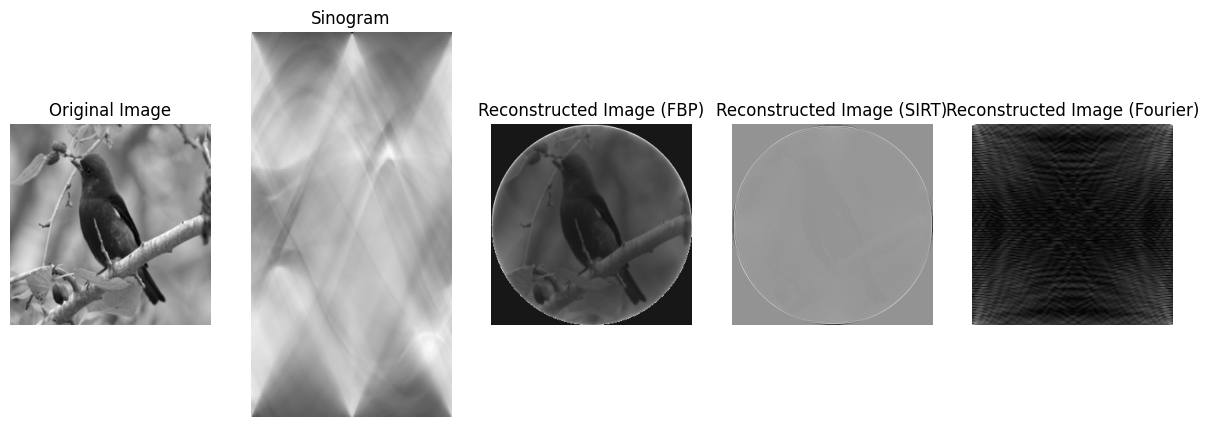

In [14]:
import numpy as np
from skimage import color, io, transform
from skimage.transform import radon, iradon, iradon_sart
import matplotlib.pyplot as plt
from numpy.fft import fftshift, fft2, ifft2
import requests
from io import BytesIO

# Step 1: Download the image from the internet
url = "https://chilternchatter.com/wp-content/uploads/2018/01/RED-Bird.jpg"
response = requests.get(url)
response.raise_for_status()  # Ensure the request was successful

# Step 2: Load the image into memory using BytesIO
image_bytes = BytesIO(response.content)
image = io.imread(image_bytes)

# Step 3: Convert the image to grayscale if it is not already
if image.ndim == 3:
    image = color.rgb2gray(image)

# Step 4: Crop or resize the image if needed (optional)
image_size = 256  # Desired size
image = transform.resize(image, (image_size, image_size))

# Step 5: Generate projection angles and sinograms
num_projections = 180  # Number of projections
angles = np.linspace(0., 180., num_projections, endpoint=False)
sinograms = radon(image, theta=angles, circle=True)

# Step 6: Define reconstruction methods

# Filtered Back Projection (FBP)
def filtered_backprojection(sinograms, angles):
    reconstructed_image = iradon(sinograms, theta=angles, circle=True)
    return reconstructed_image

# Simultaneous Iterative Reconstruction Technique (SIRT)
def sirt_reconstruction(sinograms, angles, num_iterations=50):
    reconstructed_image = iradon_sart(sinograms, theta=angles)
    for _ in range(1, num_iterations):
        reconstructed_image = iradon_sart(sinograms, theta=angles, image=reconstructed_image)
    return reconstructed_image

# Fourier-based reconstruction using Fourier Slice Theorem
def fourier_reconstruction(sinograms, angles):
    num_projections, num_pixels = sinograms.shape
    recon_image = np.zeros((num_pixels, num_pixels), dtype=np.complex128)
    mid_point = num_pixels // 2

    for i, angle in enumerate(angles):
        projection_fft = np.fft.fftshift(np.fft.fft(sinograms[:, i]))
        for j in range(num_pixels):
            x = mid_point + int((j - mid_point) * np.cos(np.deg2rad(angle)))
            y = mid_point + int((j - mid_point) * np.sin(np.deg2rad(angle)))
            if 0 <= int(x) < num_pixels and 0 <= int(y) < num_pixels:
                recon_image[int(x), int(y)] = projection_fft[j]

    recon_image = np.abs(np.fft.ifft2(np.fft.ifftshift(recon_image)))
    return recon_image

# Step 7: Perform reconstructions
reconstructed_image_fbp = filtered_backprojection(sinograms, angles)
reconstructed_image_sirt = sirt_reconstruction(sinograms, angles)
reconstructed_image_fourier = fourier_reconstruction(sinograms, angles)

# Step 8: Visualize the results
plt.figure(figsize=(15, 5))

plt.subplot(151)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(152)
plt.imshow(sinograms, cmap='gray', aspect='auto')
plt.title('Sinogram')
plt.xlabel('Projection angle (deg)')
plt.ylabel('Projection position (pixels)')
plt.axis('off')

plt.subplot(153)
plt.imshow(reconstructed_image_fbp, cmap='gray')
plt.title('Reconstructed Image (FBP)')
plt.axis('off')

plt.subplot(154)
plt.imshow(reconstructed_image_sirt, cmap='gray')
plt.title('Reconstructed Image (SIRT)')
plt.axis('off')

plt.subplot(155)
plt.imshow(reconstructed_image_fourier, cmap='gray')
plt.title('Reconstructed Image (Fourier)')
plt.axis('off')

plt.show()
